# Solar Photovoltaic installation analysis
I work on solar PV installation data in this ipython notebook. A lot of the time spent on this notebook is towards cleaning and prepping the data for analysis. Some of the noteable problems include
1. Columns that should be floats containing strings
2. Data spillage: This basically means that for certain rows, data from one column spills over to the next column, causing a domino effect with the rest of the columns leading to incorrect values.

## Some notes about the data

The Open PV Project is a collaborative effort between government, industry, and the public that continues to compile a database of available public data for photovoltaic (PV) installation data for the United States. Data for the project are voluntarily contributed from a variety of sources including solar incentive programs, utilities, installers, and the general public.

The Open PV Project is collecting data from any willing contributor of available information. The core dataset is provided by Lawrence Berkeley National Laboratory (LBL), which annually produces the Tracking the Sun report, now in its ninth year. LBL collects data from most state run incentive programs, large utilities, and other organizations. Data are also provided directly by the PV community, including installers, businesses, and consumers. The installations represented in the LBL dataset comprise about 78% of the more than 1 million installations in the Open PV database, with the rest coming from the community. It is our hope that the database will continue to grow through contributions from the PV community.



https://openpv.nrel.gov/search

In [1]:
import pandas as pd 
import numpy as np
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = (12.0, 6.0)
from mpl_toolkits.basemap import Basemap


//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
data=pd.read_csv('/Users/oladipoositelu/Desktop/data/solar_US.csv',low_memory=False)

In [332]:
#map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

In [333]:
#map.drawcoastlines()
#map.fillcontinents(color='coral',lake_color='aqua')
#map.drawstates()

# Lets look at the data

In [3]:
data.head(3)

,state,date_installed,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,cost_per_watt,...,cust_county,tracking,inv_model_clean,mod_cost_real,inv_cost_real,bos_powerclerk_real,permitting_real,3rdparty,Filters=maxdate=1472688000&maxsize=30600&mindate=946684800&minsize=10,Unnamed: 82
0,AZ,01/01/2000,UniSource Energy Services,uir,11.772,NaN,86406,residential,Epcon Solar,4.5999830105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NV,01/01/2000,NaN,uir,11.84,NaN,89010,residential,NaN,21.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TN,01/01/2000,NaN,uir,15,NaN,37923,NaN,NaN,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.shape

(65499, 83)

There are 83 columns in this dataset. Before we can do any analytical work, we need to go through all the columns and make sure they are cleaned and ready to be analyzed. We can do this by slicing the columns.

In [5]:
data.ix[:4,:7]

,state,date_installed,incentive_prog_names,type,size_kw,appraised,zipcode
0,AZ,01/01/2000,UniSource Energy Services,uir,11.772,NaN,86406
1,NV,01/01/2000,NaN,uir,11.84,NaN,89010
2,TN,01/01/2000,NaN,uir,15,NaN,37923
3,TN,01/01/2000,NaN,uir,30,NaN,37201
4,TN,01/03/2000,NaN,uir,10,NaN,37821


## What states have the most installations? the least?

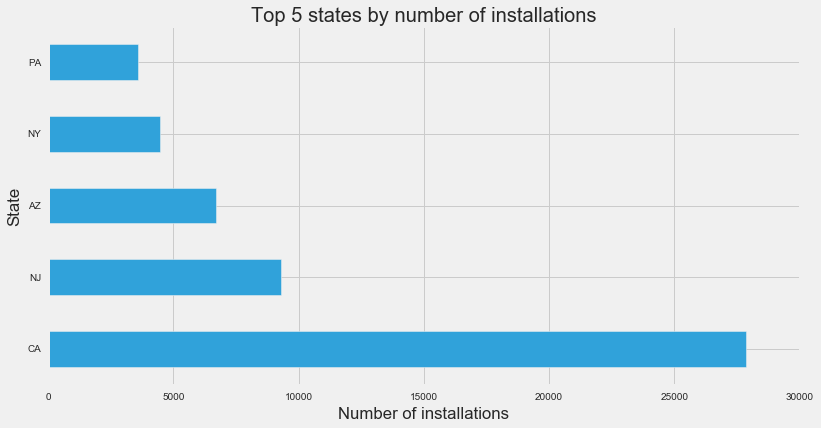

In [6]:
data['state'].value_counts().head(5).plot(kind='barh')
plt.title('Top 5 states by number of installations')
plt.ylabel('State')
plt.xlabel('Number of installations')

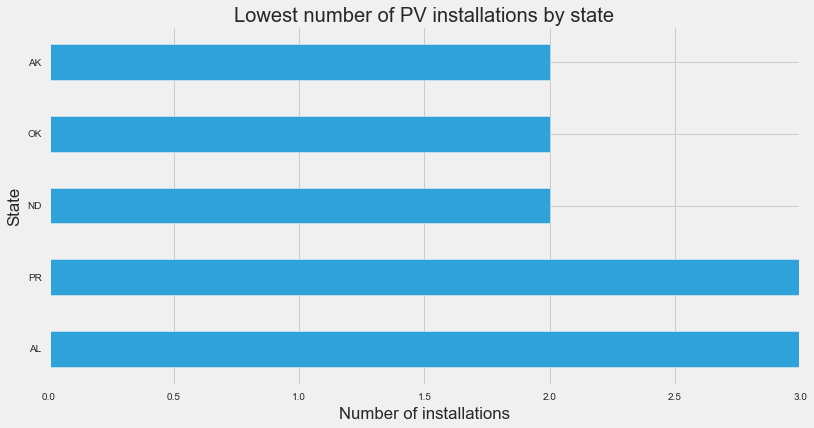

In [9]:
data['state'].value_counts().tail(5).plot(kind='barh')
plt.title('Lowest number of PV installations by state')
plt.ylabel('State')
plt.xlabel('Number of installations')

California has considerably more installations than other states. Arkansas has the least

### Convert date variable to datetime

In [10]:
data['date_installed']=pd.to_datetime(data['date_installed'])

### Let's observe the daily installations and yearly installations

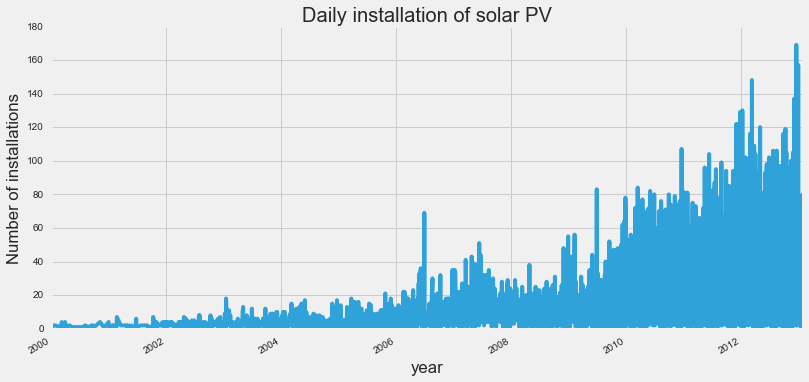

In [11]:
data['date_installed'].value_counts().plot()
plt.title('Daily installation of solar PV')
plt.xlabel('year')
plt.ylabel('Number of installations')

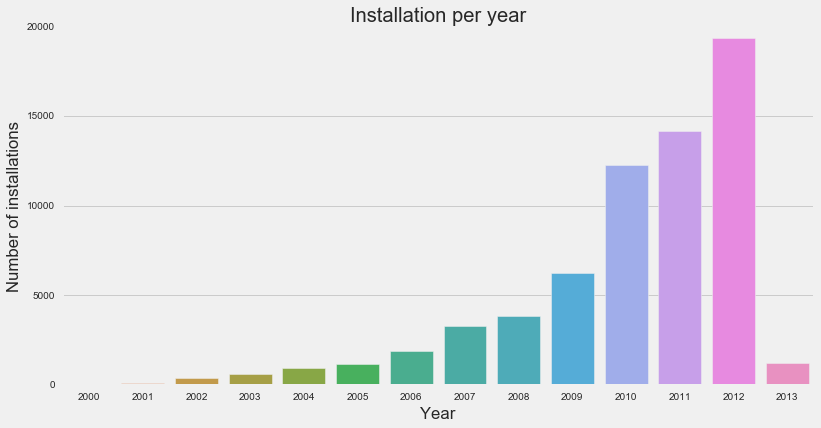

In [12]:
sns.countplot(data['date_installed'].dt.year)
plt.title('Installation per year')
plt.xlabel('Year')
plt.ylabel('Number of installations')

We can see the rising trend in yearly installations. 2013 is low because the data runs up till January 2013

### More data cleaning

If a column is meant to be a text or string column, I generally prefer to make the entire column lowercase.

In [13]:
data['incentive_prog_names']=data['incentive_prog_names'].str.lower()
data['type']=data['type'].str.lower()

Columns that should be numbers but are encoded as strings need to be converted. Most popular formats have commas that need to be removed and may also have actual words that can not be easily converted. 
First thing I want to do is write a function that checks for words in the columns. Then decide how to proceed

In [14]:
def isnot_float(data,text):
    '''Return the unique non-numeric items in a column'''
    dd=[]
    for row in data[text]:
        if type(row) is str:
            try:
                float(row.replace(',',''))
            except ValueError:
                dd.append(row)
        else:
            float(row)
    return set(dd) # return unique values

In [15]:
def str_float(data,text):
    '''Change a string column to a float'''
    dd=[]
    for row in data[text]:
        if type(row) is str:
            try:
                dd.append(float(row.replace(',','')))
            except ValueError:
                dd.append(np.nan)
        else:
            dd.append(row)
    return dd
            

### Start with size_kw

In [16]:
isnot_float(data,'size_kw')

{'uir'}

In [25]:
data.columns

Index([u'state', u'date_installed', u'incentive_prog_names', u'type',
       u'size_kw', u'appraised', u'zipcode', u'install_type', u'installer',
       u'cost_per_watt', u'cost', u'lbnl_tts_version_year', u'lbnl_tts',
       u'city', u'utility_clean', u'tech_1', u'model1_clean', u'county',
       u'annual_PV_prod', u'annual_insolation', u'rebate', u'sales_tax_cost',
       u'tilt1', u'tracking_type', u'azimuth1', u'manuf2_clean',
       u'manuf3_clean', u'manuf1_clean', u'inv_man_clean',
       u'reported_annual_energy_prod', u'incentivetype', u'year_app_implied',
       u'year', u'npv_fit_real', u'application_implied', u'npv_pbi_real',
       u'other_incentive', u'appraised_cluster', u'inflation',
       u'other_incentive_real', u'zip_available', u'cust_city', u'pbi',
       u'pbi_real', u'pbi_length', u'application', u'fit_length', u'fit_rate',
       u'fit_payment', u'_3rdparty_implied', u'utility',
       u'install_price_real_w', u'install_price', u'installer_clean',
       u'manu

uir seems like a value that should be in the type column not size_kw. Lets just take a closer look

In [20]:
print "The number of rows with this problem:", len(data[data['size_kw']== 'uir'])

The number of rows with this problem: 215


In [21]:
data[data['size_kw']== 'uir'].head(10)

,state,date_installed,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,cost_per_watt,...,cust_county,tracking,inv_model_clean,mod_cost_real,inv_cost_real,bos_powerclerk_real,permitting_real,3rdparty,Filters=maxdate=1472688000&maxsize=30600&mindate=946684800&minsize=10,Unnamed: 82
12311,NM,2009-01-06,new mexico energy,minerals and natural resources department,uir,13.5,NaN,87531,NaN,Paradise Power,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13447,NM,2009-03-31,new mexico energy,minerals and natural resources department,uir,10.125,NaN,87501,NaN,Positive Energy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13501,NM,2009-04-03,new mexico energy,minerals and natural resources department,uir,10.8,NaN,87501,NaN,Positive Energy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13978,NM,2009-05-14,new mexico energy,minerals and natural resources department,uir,30.625,NaN,87734,NaN,Energy Concepts,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14695,NM,2009-06-30,new mexico energy,minerals and natural resources department,uir,16.2,NaN,87505,NaN,Positive Energy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15069,NM,2009-07-24,new mexico energy,minerals and natural resources department,uir,15.488,NaN,87111,NaN,Self,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16892,NM,2009-11-01,new mexico energy,minerals and natural resources department,uir,11.648,NaN,87509,NaN,Two J Builders,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17244,DC,2009-11-18,washington,dc department of energy & environment,uir,27,NaN,20016,educational,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17250,NM,2009-11-18,new mexico energy,minerals and natural resources department,uir,10.66,NaN,87110,residential,Ve Group,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18181,NM,2009-12-23,new mexico energy,minerals and natural resources department,uir,10.35,NaN,87144,NaN,Consolidated Solar Technologies,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


it seems for this set of data, values from incentive programs names spills into values for type causeing a domino effect with the other columns. This is a potentially big issue. 
I will do a lot of slicing to solve this

1. First I'll divide the dataset into two, those with size_kw=='uir' call this test and those that are normal(call it data1)
2. the values from type should be part of the values for incentive_prog_names

In [22]:
data1=data[data.size_kw !='uir']

In [23]:
test=data[data['size_kw']=='uir']

add together the rows that need to be added

In [24]:
test['incentive_prog_names']=test['incentive_prog_names'] + test['type']

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Split the data into columns 3 to 8

In [26]:
cols=test.columns[3:82] 

In [27]:
new_test=test.ix[:,4:] #select data from column 4 till the end

In [28]:
new_test.columns=cols

In [29]:
print data1.shape
print data.shape
print new_test.shape
print cols.shape

(65284, 83)
(65499, 83)
(215, 79)
(79,)


In [30]:
df=pd.concat([data1,new_test])

In [31]:
data=df[list(data.columns)]

In [32]:
data.head()

,state,date_installed,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,cost_per_watt,...,cust_county,tracking,inv_model_clean,mod_cost_real,inv_cost_real,bos_powerclerk_real,permitting_real,3rdparty,Filters=maxdate=1472688000&maxsize=30600&mindate=946684800&minsize=10,Unnamed: 82
0,AZ,2000-01-01,unisource energy services,uir,11.772,NaN,86406,residential,Epcon Solar,4.5999830105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NV,2000-01-01,NaN,uir,11.84,NaN,89010,residential,NaN,21.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TN,2000-01-01,NaN,uir,15,NaN,37923,NaN,NaN,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TN,2000-01-01,NaN,uir,30,NaN,37201,NaN,NaN,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TN,2000-01-03,NaN,uir,10,NaN,37821,NaN,NaN,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
data['size_kw']=str_float(data,'size_kw')

In [40]:
data['size_kw'].describe()

count    65499.000000
mean       100.928089
std        575.682565
min         10.000000
25%         11.340000
50%         15.640000
75%         42.512500
max      30000.000000
Name: size_kw, dtype: float64

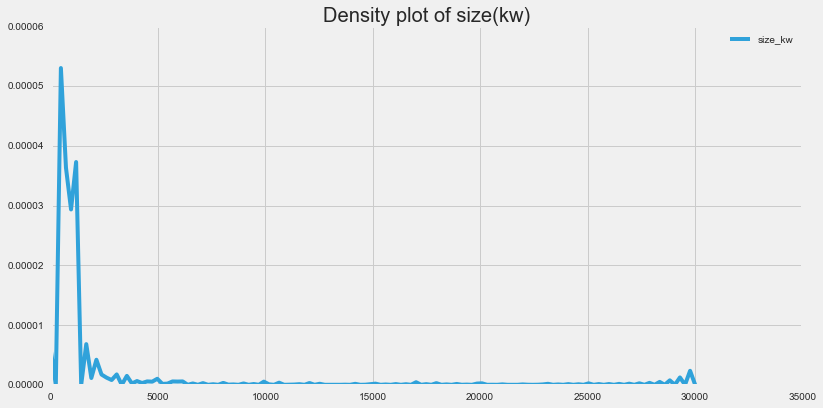

In [42]:
sns.kdeplot(data.size_kw)
plt.title('Density plot of size(kw)')

We can see that there's a skew in the distribution, heavy tail to the right

In [43]:
isnot_float(data,'zipcode')

set()

In [45]:
data['zipcode']=(str_float(data,'zipcode'))
data['zipcode']=data['zipcode'].astype(int)

In [46]:
data.ix[:5,7:14]

,install_type,installer,cost_per_watt,cost,lbnl_tts_version_year,lbnl_tts,city
0,residential,Epcon Solar,4.5999830105,"54,151",2016,TRUE,LAKE HAVASU CITY
1,residential,NaN,21.11,250000,NaN,NaN,NaN
2,NaN,NaN,8,120000,NaN,NaN,NaN
3,NaN,NaN,8,240000,NaN,NaN,NaN
4,NaN,NaN,8,80000,NaN,NaN,NaN
5,NaN,NaN,7.4932699045,"81,278",2016,TRUE,Moss Beach


In [47]:
data['install_type']=data['install_type'].str.lower()

In [48]:
np.sort(data['install_type'].unique())

array([nan, 'agricultural', 'agriculture', 'commercial',
       'commercial - builders', 'commercial - other',
       'commercial - small business', 'commerical', 'customer',
       'education', 'educational', "gov't/np", 'government',
       'institutional', 'municipal', 'nonprofit', 'nonresidential',
       'public', 'residential', 'small business', 'unknown', 'utility'], dtype=object)

There are obviously some duplications that can easily be solved

In [49]:
dd=[]
for row in data['install_type']:
    if row=='agricultural':
        dd.append('agriculture')
    elif row=='commerical':
        dd.append('commercial')
    elif row=='educational':
        dd.append('education')
    elif row=='small business':
        dd.append('commercial - small business')
    elif pd.isnull(row):
        dd.append('unknown')
    else:
        dd.append(row)
    

In [50]:
data['install_type']=dd

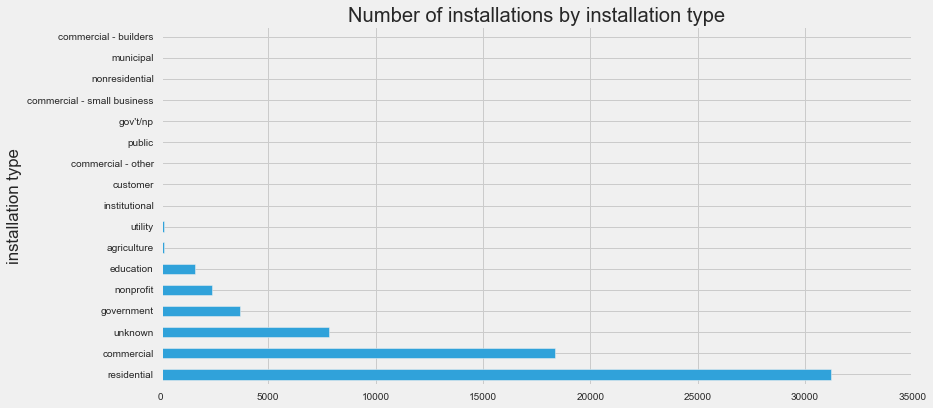

In [53]:
data['install_type'].value_counts().plot(kind='barh')
plt.ylabel('installation type')
plt.title('Number of installations by installation type')

In [54]:
data['installer']=data['installer'].str.lower()

In [55]:
isnot_float(data,'cost_per_watt')

{' Inc',
 ' Inc.',
 ' Inc.;Old Goat Enterprises',
 ' LLC',
 ' LLC - David Fairbank (and Bates Electric)',
 ' LLC T/A JERSEY SOLAR ELECT',
 ' inc.'}

We have a few values that shouldn't be in the column. Lets see why

In [56]:
data['cost_per_watt']=data['cost_per_watt'].str.lower().str.strip()

In [57]:
test2=data[(data['cost_per_watt'].str.contains('inc')==True) | (data['cost_per_watt'].str.contains('llc')==True)]

In [58]:
test2.shape

(62, 83)

In [66]:
test2.ix[:,7:14].head()

,install_type,installer,cost_per_watt,cost,lbnl_tts_version_year,lbnl_tts,city
1334,residential,jersey solar,llc t/a jersey solar elect,8.0260416667,"154,100",2016,TRUE
3008,commercial,jersey solar,llc t/a jersey solar elect,7.2,"95,760",2016,TRUE
4335,residential,jersey solar,llc t/a jersey solar elect,8.0729166667,"155,000",2016,TRUE
4996,commercial,jersey solar,llc t/a jersey solar elect,7,"720,300",2016,TRUE
7882,residential,jersey solar,llc t/a jersey solar elect,7.8765555002,"79,120",2016,TRUE


It seems like we have the same problem we had earlier with data not being in the right place

In [72]:
cols2=test2.columns[9:82]
new_test=test2.ix[:,10:]
new_test.columns=cols2

In [73]:
data2=data[(data['cost_per_watt'].str.contains('inc')==False) & (data['cost_per_watt'].str.contains('llc')==False) | (pd.isnull(data.cost_per_watt))]

In [76]:
df=pd.concat([data2,new_test])
data=df[data.columns]

In [79]:
isnot_float(data,'cost_per_watt')

set()

In [80]:
data['cost_per_watt']=str_float(data,'cost_per_watt')

In [83]:
data['cost_per_watt'].describe()

//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    54931.000000
mean         6.326263
std          1.873974
min          0.763807
25%               NaN
50%               NaN
75%               NaN
max         30.000000
Name: cost_per_watt, dtype: float64

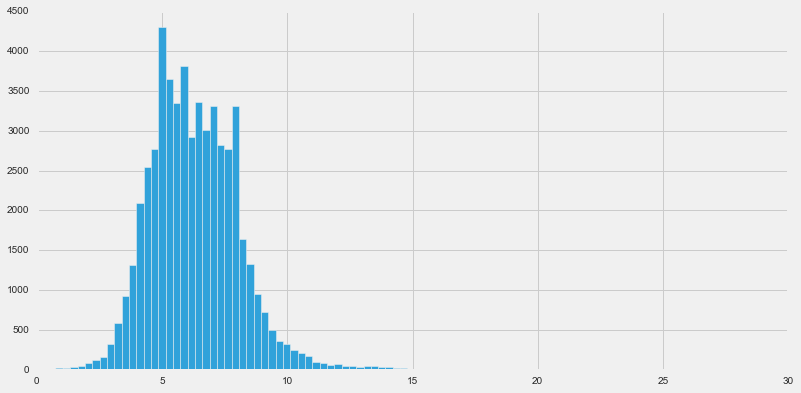

In [85]:
data['cost_per_watt'].hist(bins=100)

In [81]:
isnot_float(data,'cost')

{'n/a'}

In [82]:
data['cost']=str_float(data,'cost')

In [86]:
data['cost'].describe()

count    5.494300e+04
mean     4.006457e+05
std      1.566098e+06
min      0.000000e+00
25%               NaN
50%               NaN
75%               NaN
max      1.522000e+08
Name: cost, dtype: float64

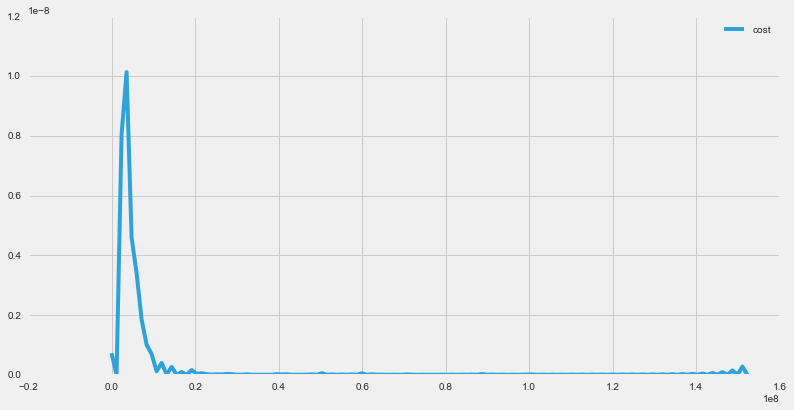

In [90]:
sns.kdeplot(data.cost)

In [91]:
isnot_float(data,'lbnl_tts_version_year')

set()

In [92]:
data['lbnl_tts_version_year']=str_float(data,'lbnl_tts_version_year')

In [97]:
print data['lbnl_tts_version_year'].value_counts()
data['lbnl_tts'].value_counts()

2016.0    36353
Name: lbnl_tts_version_year, dtype: int64


TRUE    36353
Name: lbnl_tts, dtype: int64

The usefullness of these columns not so clear. I should drop one or both?

In [99]:
del data['lbnl_tts']

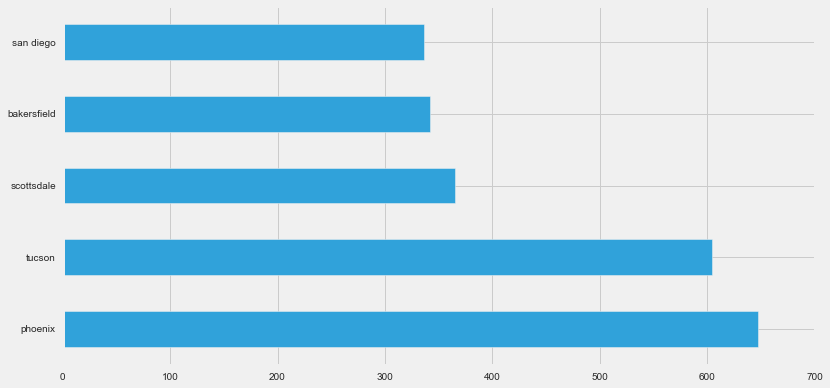

In [102]:
data['city']=data['city'].str.lower()
data['city'].value_counts().head().plot(kind='barh')

In [114]:
data.ix[:5,13:20]

,utility_clean,tech_1,model1_clean,county,annual_PV_prod,annual_insolation,rebate
0,UniSource Energy Services,NaN,NaN,Mohave,NaN,NaN,"1,177.2"
1,NaN,NaN,NaN,Esmeralda,NaN,NaN,NaN
2,NaN,NaN,NaN,Knox,NaN,NaN,NaN
3,NaN,NaN,NaN,Davidson,NaN,NaN,NaN
4,NaN,NaN,NaN,Cocke,NaN,NaN,NaN
5,Pacific Gas & Electric Company,NaN,NaN,San Mateo,"16,774.2849",5.374998569,"27,117"


In [115]:
data['utility_clean']=data['utility_clean'].str.lower()

In [118]:
data['tech_1']=data.tech_1.str.lower()

In [120]:
data['model1_clean']=data.model1_clean.str.lower()
data['county']=data['county'].str.lower()

In [121]:
isnot_float(data,'annual_PV_prod')

{'Coos',
 'Douglas',
 'Gadsden',
 'Linn',
 'Mora',
 'Sangamon',
 'Washoe',
 'Worcester'}

In [34]:
def is_string(data,text):
    dd=[]
    for row in data[text]:
        dd.append(type(row))
    return dd